# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework #2
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, Febrary 9th, 2018 at 10:59 am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [31]:
import numpy as np
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
from functools import partial

## Problem 1: Monte Carlo Integration

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$
h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}
$$

Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:
- inverse transform sampling
- rejection sampling with both uniform proposal distribution and normal proposal distribution (steroids) (with appropriately chosen parameters)


### REVIEW OF SIMULATION AND SAMPLING
**(If you're solid on the theoretical underpinning of these methods or are more interested in implementation, you might not find this helpful)**

### 0. Review of Monte Carlo Simulation
Let's define $Y = h(X)$. Since $X$ is a random variable, so too is $Y$. Thus, it make sense to compute its mean, that is, to compute 
$$\mathbb{E}[Y] = \mathbb{E}[h(X)].$$ 
Recall, from Week 1 (review of statistics) and Homework 1, that a good (meaning consistent and unbiased) estimator of the mean (or expected value) of a random variable is the *sample mean*. That is, we can approximate the mean of $Y$ by sampling $n$ number of values of $Y$ and then computing the average of these values:
$$
\mathbb{E}[Y] \approx \frac{1}{n} \sum_{i=1}^n Y^{(i)},
$$
where each $Y^{(i)}$ is drawn independently from the distribution of $Y$. 

But how do we generate $n$ number of values of $Y$? Since $Y$ is a (deterministic) function of $X$, we can generate $n$ number of values of $Y$ by:

1. independently drawing $n$ number of values of $X$, where $X^{(i)} \sim f_X$, for $1 \leq i \leq n$. 
2. plug in the $n$ values of $X$ into $h$, obtaining $Y^{(i)} = h(X^{i})$, for $1 \leq i \leq n$.

Thus, we can estimate the mean of $Y$ as follows:
$$
\mathbb{E}[Y] = \mathbb{E}[h(X)] \approx \frac{1}{n} \sum_{i=1}^n h(X^{(i)}), \quad X^{(i)}\sim f_X
$$

Let's define $\bar{Y}_n$ to be our estimate $\frac{1}{n} \sum_{i=1}^n h(X^{(i)})$. To re-iterate, $\bar{Y}_n$ is an good estimator of $\mathbb{E}[Y]$ because:

- **$\bar{Y}_n$ is unbiased**: $\mathbb{E}[\bar{Y}_n] = \mathbb{E}[Y]$
- **$\bar{Y}_n$ is consistent**: $\lim_{n\to \infty}\bar{Y}_n = \mathbb{E}[Y]$ 


>**An IF-YOU-CARE, SUPER TECHNICAL Note:** more precisely, the second statement should be "the probability of $\lim_{n\to \infty}\bar{Y}_n = \mathbb{E}[Y]$ is 1" or "$\lim_{n\to \infty}\bar{Y}_n = \mathbb{E}[Y]$ almost surely". Furthermore, the statement that "$\lim_{n\to \infty}\bar{Y}_n = \mathbb{E}[Y]$ almost surely" is actually stronger than requiring $\bar{Y}_n$ to be a  consistent estimator, the latter only requiring the probability of $|\lim_{n\to \infty}\bar{Y}_n -  \mathbb{E}[Y]| \geq \epsilon$ to be zero for every $\epsilon >0$. 

The variance of the estimator $\bar{Y}_n$ is equal to $\frac{\sigma^2}{n}$, where $\sigma = \mathrm{Var}[Y]$ (this is given by the Central Limit Theorem).

**CONCLUSION:** 
So, it appears that estimating $\mathbb{E}[Y] = \mathbb{E}[h(X)]$ is easy as long as we can sample from $f_X$. The problem is that, in practice, we often work with pdf's that are easy to evalutate but difficult to sample from. In our case, we can easily compute $f_X(x)$ when we are given a number $x \in \mathbb{R}$, but it's not clear how to generate values of $x$ from the distribution described by $f_X$. 

In the following sections, we address the difficulty of sampling from $f_X$. 

### I. Inverse Transform Sampling

The idea behind Inverse Transform Sampling is that while it is sometimes difficult to generate values for $X$ with the relative frequency described by pdf, $f_X$, it can be easier to generate values for $X$ using the CDF. 

The intuition is as follows:

1. While the support of the pdf and CDF can be unbounded, the range of the CDF is bounded between 0 and 1.
2. The CDF for a continuous single-variable pdf is an invertible function (on the support of the pdf). That is, each value between 0 and 1 corresponds to a unique value of the random variable $X$.
3. Values of $X$ that lie under peaks of the pdf occupy larger portions of the interval [0, 1]. That is, the range of the CDF, [0, 1], can be subdivided to exactly reflect the areas of high probability mass and low probability mass under the pdf. 

So if we uniformly sample values in the range of the CDF, [0, 1] and find the corresponding $X$ values for these samples (using the inverse function of the CDF), we obtain samples of $X$. 

### II. Rejection Sampling
The idea behind Rejection Sampling is to by-pass the problem of sampling from a difficult distribution $f_X$, by:

1. approximating $f_X$ (this is called the target distribution) with a pdf $g$ (this is called the proposal distribution) that is easy to sample
2. sample from $g$ and reject the samples that are unlikely to be from $f_X$

More precisely, we choose a proposal distribution $g$ and a non-zero constant $M$ such that $f_X \leq M\cdot g$. A sample $X = x$ generated from $g$ is accepted with probability $\frac{f_X}{M g}$. One can compute that the expected number of times it takes to draw and accept a sample $X=x$ is precisely $M$. This means that roughly $(M-1)/M$ of samples drawn from $g$ will be rejected. 

Typically, if $n$ number of samples of values of $X$ are desired, one would repeated draw from $g$ until $n$ samples have been accepted. Otherwise, if one draws a $n$ samples from $g$, the lower number of accepted samples will lead to greater variance in your Monte Carlo estimates.

### III. Stratified Sampling
The intuition for stratified sampling is that while computing the integral for $\mathbb{E}[Y]$ maybe difficult, we might be able to break up the domain of $Y$ in to strata so that the integral becomes simplified (or has other desirable properties) on each piece of the strata.

For example, suppose the domain of $Y$ is all of the real numbers $\mathbb{R}$. Let's break up $\mathbb{R}$ into $m$ number of strata, each of which is an interval:
$$
(-\infty, r_1], (r_1, r_2], \ldots, (r_{m-2}, r_{m-1}], (r_{m-1}, \infty)
$$
Then we can rewrite the integral for $\mathbb{E}[Y]$:
$$
\mathbb{E}[Y] = \mathbb{E}[h(X)] = \sum_{j=1}^m \int_{[r_{j-1}, r_j]} h(x) f_X(x)dx.
$$
Unfortunately, it is not clear how to estimate each subintegral, $\int_{[r_{j-1}, r_j]} h(x) f_X(x)dx$, since $f_X$ is not a proper pdf over $[r_{j-1}, r_j]$. What we need to do is to normalize $f_X$ over each interval $[r_{j-1}, r_j]$. That is,
$$
\mathbb{E}[Y] = \mathbb{E}[h(X)] = \sum_{j=1}^m w_j \int_{[r_{j-1}, r_j]} \frac{1}{w_j} h(x) f_X(x)\mathbb{I}(x\in [r_{j-1}, r_j]) dx,
$$
where $w_j = \int_{[r_{j-1}, r_j]} f_X(x) dx$ is the area under the curve of $f_X$ over $[r_{j-1}, r_j]$ and $f_X(x)\mathbb{I}(x\in [r_{j-1}, r_j])$ is just $f_X$ redefined to be zero outside of $[r_{j-1}, r_j]$.

Now, we can estimate $\mathbb{E}[Y]$ as follows:
$$
\mathbb{E}[Y] = \mathbb{E}[h(X)] \approx \sum_{j=1}^m w_j\left[\frac{1}{n_j}\sum_{i=1}^{n_j}h(X^{ij})\right], \quad X^{ij} \sim \frac{1}{w_j} f_X(x)\mathbb{I}(x\in [r_{j-1}, r_j])
$$
***Plainly put:*** 
1. we break up the domain in to $m$ number of strata
2. we sample $n_j$ number of points from the $j$-th strata. Making sure that $n = \sum_{j=1}^m n_j$.
3. we take plug in these $n_j$ number of points into $h$ and take the average
4. we take a weighted average of the averages to estimate $\mathbb{E}[Y]= \mathbb{E}[h(X)]$.

Let's define $\bar{Y}^{SS}_n = \sum_{j=1}^m w_j\left[\frac{1}{n_j}\sum_{i=1}^{n_j}h(X^{ij})\right]$. We can again show that $\bar{Y}^{SS}_n$ is an unbiased estimator of $\mathbb{E}[Y]$. We can also derive the variance of our estimator:
$$
\mathrm{Var}[\bar{Y}^{SS}_n] = \sum_{j=1}^m w_j^2 \frac{\sigma_j^2}{n_j},
$$
where $\sigma^2_j$ is roughly the variance of $Y$ restricted to the interval $[r_{j-1}, r_j]$. 

The explicit formulation of the variance of $\bar{Y}^{SS}_n$ allow us to choose the stratification (splitting of the domain) and the sampling scheme (how many points to take from each strata) that will minimize variance. In particular, we see that if $\sigma_j$ is zero for all strata, then the variance or our stratified sampling method will be zero.

---

**Solutions:**

The piecewise definition of the pdf looks intimidating at first glance, so let's visualize it.

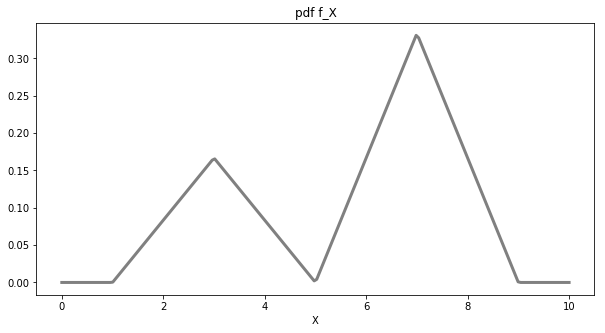

In [32]:
#pdf
def f_X(x):
    if x >= 1 and x <= 3:
        return 1./12 * (x - 1.)
    elif x > 3 and x <= 5:
        return -1./12 * (x - 5)
    elif x > 5 and x <= 7:
        return 1./6 * (x - 5)
    elif x > 7 and x <= 9:
        return -1./6 * (x - 9)
    else:
        return 0.

# vectorize f_X so we can apply it to a numpy array
vector_f_X = np.vectorize(f_X)

#visualize pdf
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, vector_f_X(x), color='gray', linewidth=3)
ax.set_xlabel('X')
ax.set_title('pdf f_X')
plt.show()

#### Inverse Transform Sampling

Recall that the CDF, $F_X$, of our pdf $f_X$ is defined as:
$$
F_X(a)= \int_{-\infty}^a f_X(x)dx, \quad a\in \mathbb{R}
$$
That is, $F_X(a)$ is the area under $f_X$ up to $X=a$. Now, since our pdf is zero when $X < 1$. We rewrite the above as
$$
F_X(a)= \int_{1}^a f_X(x)dx, \quad a\in \mathbb{R}
$$

Since our function is defined piecewise, we can compute the CDF on each piece. We demonstrate this process for the third piece, $5< x\leq 7$:

- the pdf over $[5, 7]$ has the form $\frac{1}{6}(x-5)$; 
- an antiderivative is $\frac{1}{6}\left(\frac{1}{2}x^2-5x\right)$; 
- the CDF over $[5, 7]$ is the area under $f_X$ from $X=1$ to $X=a$, $a\in [5, 7]$;

**Be careful:** you cannot compute the CDF as follows (simply by using the Fundamental Theorem)
$$
F_X(a)= \int_{1}^a f_X(x)dx = \left.\frac{1}{6}\left(\frac{1}{2}x^2-5x\right) \right|_{1}^{a}, \quad a\in [5, 7]
$$
This is because the functional form of the antiderivative is different out side of the interval [5, 7]!

Instead, we break up the pdf as follows:
\begin{aligned}
F_X(a) &= \int_{5}^a f_X(x)dx  + \int_{1}^5 f_X(x)dx \\
&= \left.\frac{1}{6}\left(\frac{1}{2}x^2-5x\right) \right|_{5}^{a} + \frac{1}{3} \\
&= \frac{1}{6}(a^2/2-5a) + \frac{25}{12} + \frac{1}{3}, \quad a\in [5, 7],
\end{aligned}
In the above, we note that the area $\int_{1}^5 f_X(x)dx$ is the area of the small triangle, which is 1/3. 

The shaded region below illustrates the value of $F_X(a)$ for $a\in [5, 7]$.

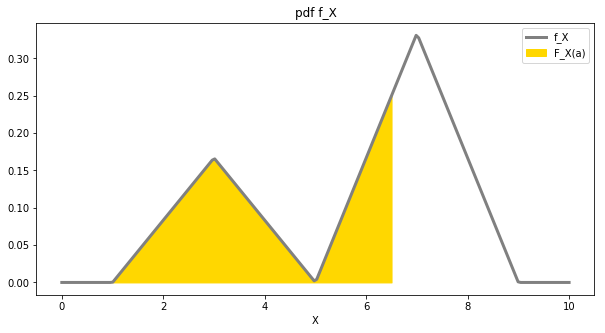

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, vector_f_X(x), color='gray', linewidth=3, label='f_X')
x = np.linspace(1, 6.5, 200)
ax.fill_between(x, vector_f_X(x), color='gold', label='F_X(a)')
ax.set_xlabel('X')
ax.set_title('pdf f_X')
ax.legend(loc='best')
plt.show()

In a similar manner, we compute expressions for the CDF of $X$ on all four pieces of the domain:
$$
F_X(x) = \begin{cases}
0, & x < 1 \\
\frac{1}{12}(x^2/2-x) + \frac{1}{24}, &1\leq x\leq 3\\
-\frac{1}{12}(x^2/2-5x) - \frac{7}{8} + \frac{1}{6}, &3< x\leq 5\\
\frac{1}{6}(x^2/2-5x) + \frac{25}{12} + \frac{1}{3}, &5< x\leq 7\\
-\frac{1}{6}(x^2/2 - 9x) - \frac{77}{12} + \frac{2}{3}, &7< x\leq 9\\
1, &9 < x
\end{cases}
$$
Each piece of $F_X$ can now be inverted, with the help of [WolframAlpha](https://www.wolframalpha.com) if you'd like:
$$
F^{-1}_X(y) = \begin{cases}
1 + 2\sqrt{6y}, &0\leq y\leq \frac{1}{6}\\
5 - 2\sqrt{2(1 - 3y)}, &\frac{1}{6}< y\leq \frac{1}{3}\\
5 + 2\sqrt{3y - 1}, &\frac{1}{3}< y\leq \frac{2}{3}\\
9 - 2\sqrt{3(1 - y)}, &\frac{2}{3}< y\leq 1\\
\end{cases}
$$

We now have all the pieces we need to sample from $f_X$.

In [34]:
#inverse of CDF
def F_inv_X(y):
    if y >= 0 and y <= 1./6:
        return 1 + 2 * np.sqrt(6 * y)
    elif y > 1./6 and y <= 1./3:
        return 5 - 2 * np.sqrt(2 * (1 - 3 * y))
    elif y > 1./3 and y <= 2./3:
        return 5 + 2 * np.sqrt(3 * y - 1)
    elif y > 2./3 and y <= 1.:
        return 9 - 2 * np.sqrt(3 * (1 - y))
    else:
        return np.nan
    

#function h
def h(x):
    return 1./(3 * 2**.5 * np.pi) * np.exp(-1./18 * (x - 5)**2)

# vectorize the above functions 
vector_F_inv_x = np.vectorize(F_inv_X)
vector_h = np.vectorize(h)

#inverse transform sampling
def inverse_transform(h, F_inv_X, n):

    #1. sample y-values uniformly from [0, 1]
    y = np.random.uniform(0, 1, n)

    #2. turn these y-values into x-values using the inverse CDF
    x_samples = vector_F_inv_x(y)

    #3. apply h to the x-values and average
    mean_inv = np.mean(vector_h(x_samples))
    
    return x_samples, mean_inv

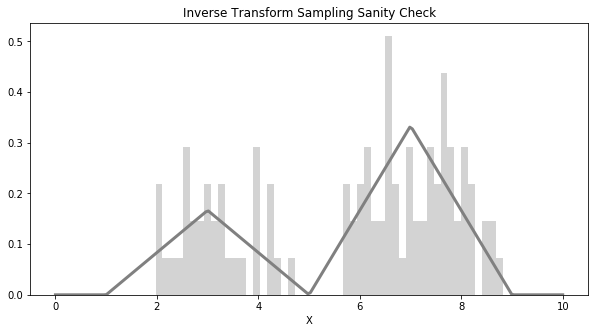

Inverse Transform estimate of E[h(x)]: 0.05830469544778119


In [35]:
n_samples = 100 #number of samples to draw

x_samples, mean_inv = inverse_transform(h, F_inv_X, n_samples)

#Sanity check: make sure these x-values look like they 
#are from the correct distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, vector_f_X(x), color='gray', linewidth=3)
ax.hist(x_samples, bins=50, normed=1, color='lightgray', linewidth=0)
ax.set_xlabel('X')
ax.set_title('Inverse Transform Sampling Sanity Check')
plt.show()

print('Inverse Transform estimate of E[h(x)]: {}'.format(mean_inv))

#### Rejection Sampling

Setting up rejection sampling requires us to find a constant $M$ such that $f_X \leq M g$ where $g$ is the proposal distribution. In general, we want $M$ to be as small as possible. However, in this case we will simply pick a $M$ based on visualizations.

In [36]:
#setting up our proposal distributions

#normal pdf: for sampling and evaluation
def normal_dist(mu, sigma, x=None, n=None):
    if x is not None:
        return norm.pdf(x, mu, sigma)
    elif n is not None:
        return np.random.normal(mu, sigma, n)
    else:
        return None

#uniform pdf: for sampling and evaluation
def uniform_dist(a, b, x=None, n=None):
    if x is not None:
        return np.array([1. / (b - a)] * len(x))
    elif n is not None:
        return np.random.uniform(a, b, n)
    else:
        return None

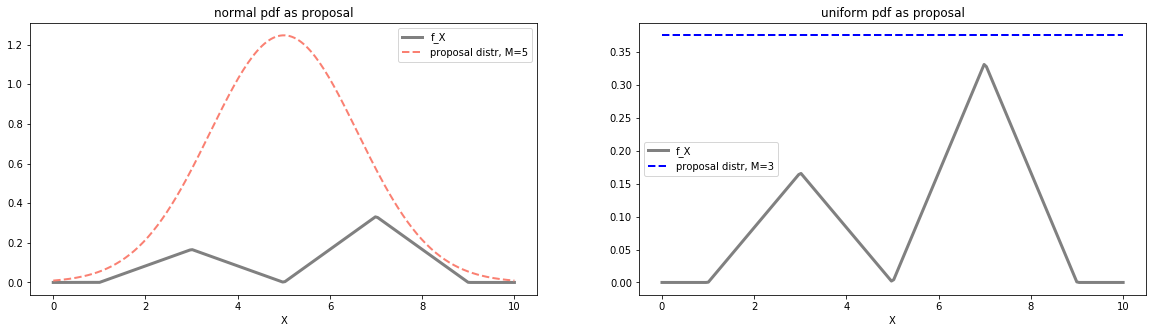

In [37]:
prop_1 = partial(normal_dist, mu=5, sigma=1.6)
M_1 = 5

prop_2 = partial(uniform_dist, a=1, b=9)
M_2 = 3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(0, 10, 200)
ax1.plot(x, vector_f_X(x), color='gray', linewidth=3, label='f_X')
ax1.plot(x, M_1 * prop_1(x=x), '--', color='salmon', linewidth=2, label='proposal distr, M={}'.format(M_1))
ax1.set_xlabel('X')
ax1.set_title('normal pdf as proposal')
ax1.legend(loc='best')

ax2.plot(x, vector_f_X(x), color='gray', linewidth=3, label='f_X')
ax2.plot(x, M_2 * prop_2(x=x), '--', color='blue', linewidth=2, label='proposal distr, M={}'.format(M_2))
ax2.set_xlabel('X')
ax2.set_title('uniform pdf as proposal')
ax2.legend(loc='best')
plt.show()

Now for the rejection sampling:

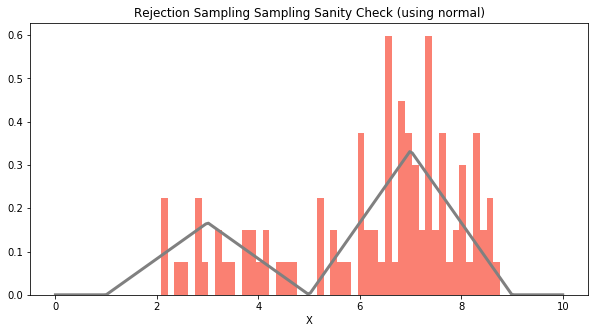

Rejection Sampling estimate of E[h(x)] (using normal): 0.05879176692159373


In [38]:
def rejection(n, prop_dist, M, true_dist, h):
    samples = []
    while len(samples) < n:
        sample = prop_dist(n=1)
        if np.random.uniform(0, M * prop_dist(x=sample)) <= true_dist(sample):
            samples.append(sample[0])    
    mean_rej = np.mean(vector_h(samples))
    return samples, mean_rej

x_samples, mean_rej = rejection(n_samples, prop_1, M_1, f_X, h)

#Sanity check: make sure these x-values look like they 
#are from the correct distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, vector_f_X(x), color='gray', linewidth=3)
ax.hist(x_samples, bins=50, normed=1, color='salmon', linewidth=0)
ax.set_xlabel('X')
ax.set_title('Rejection Sampling Sampling Sanity Check (using normal)')
plt.show()

print('Rejection Sampling estimate of E[h(x)] (using normal): {}'.format(mean_rej))

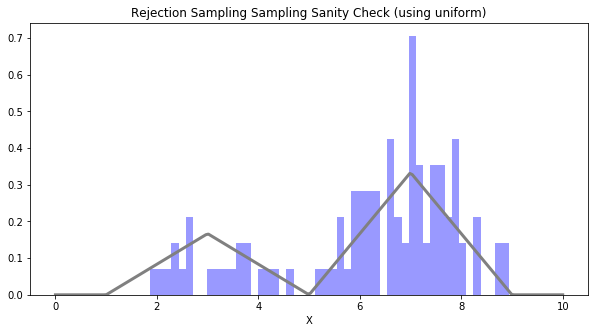

Rejection Sampling estimate of E[h(x)] (using uniform): 0.05913984415326059


In [39]:
x_samples, mean_rej = rejection(n_samples, prop_2, M_2, f_X, h)

#Sanity check: make sure these x-values look like they 
#are from the correct distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 200)
ax.plot(x, vector_f_X(x), color='gray', linewidth=3)
ax.hist(x_samples, bins=50, normed=1, color='blue', linewidth=0, alpha=0.4)
ax.set_xlabel('X')
ax.set_title('Rejection Sampling Sampling Sanity Check (using uniform)')
plt.show()

print('Rejection Sampling estimate of E[h(x)] (using uniform): {}'.format(mean_rej))

## Problem 2: Variance Reduction

### Part A

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ obtained in Problem 1. What do you see?

**Solutions:**

***Disclaimer*** In the solutions, we've implemented these sampling methods to increase readability (for example, the functions are defined exactly as they are written mathematically). However, this makes them slow to evaluate. We ***highly*** encourage you to explore ways fo increasing the efficiency of these implementations.

In [40]:
n_simulations = 100

var_inv = np.std([inverse_transform(h, F_inv_X, n_samples)[1] for i in range(n_simulations)])
var_rej_1 = np.std([rejection(n_samples, prop_1, M_1, f_X, h)[1] for i in range(n_simulations)])
var_rej_2 = np.std([rejection(n_samples, prop_2, M_2, f_X, h)[1] for i in range(n_simulations)])

print('std of inverse transform: {}'.format(var_inv))
print('std of rejection with normal: {}'.format(var_rej_1))
print('std of rejection with uniform: {}'.format(var_rej_2))

std of inverse transform: 0.0009373017499406047
std of rejection with normal: 0.0009587268325971548
std of rejection with uniform: 0.0010113942417401196


We observe that while the proposal distribution doesn't have a big impact on the variance associated with rejection sampling (this is expected - from the review we know that the choice of proposal distribution largely effects the efficiency of the sampling method).

For our proposal distributions, we'd chosen a uniform distribution and a normal distribution with mean 5 and variance 1.6. It is very possible that these distribution are inappropriate for our distribution $f_X$ and function $h$.

Let's plot $f_X \cdot h$ and see how well the normal distribution captures the trends in this product.

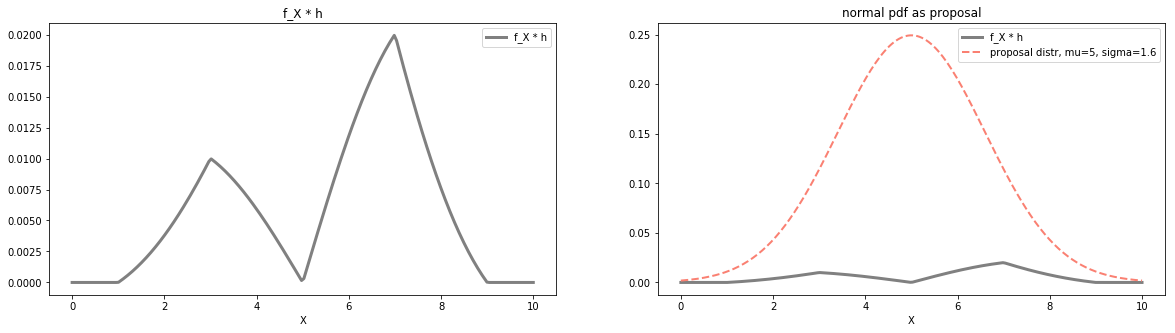

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(0, 10, 200)
f_X_h = np.vectorize(lambda x: f_X(x) * h(x))

ax1.plot(x, f_X_h(x), color='gray', linewidth=3, label='f_X * h')
ax1.set_xlabel('X')
ax1.set_title('f_X * h')
ax1.legend(loc='best')

ax2.plot(x, f_X_h(x), color='gray', linewidth=3, label='f_X * h')
ax2.plot(x, prop_1(x=x), '--', color='salmon', linewidth=2, label='proposal distr, mu={}, sigma={}'.format(5, 1.6))
ax2.set_xlabel('X')
ax2.set_title('normal pdf as proposal')
ax2.legend(loc='best')
plt.show()

We see that the problem that our pdf $f_X$ is bimodal (has two peaks), while a normal pdf has only one. If we restrict ourselves to using either uniform or normal proposal distributions, it is not possible to satisfy $g \propto f_X \cdot h$. 


#### HOW TO DEBUG YOUR MONTE CARLO INTEGRATORS:
Some of you, when you noticed that importance sampling was producing results with higher variance, were anxious that you'd incorrectly implemented importance sampling. Our empirical estimate of the standard deviation correspoonding to importance sampling is `0.00412883983954` for 100 samples; on the other hand, from the review, we know that the variance associated to the method can be calculated as:
$$
\mathrm{Var}_g[\bar{Y}^g_n] = \frac{\mathrm{Var}_g[Y]}{n}, \quad \mathrm{Var}_g[Y] = \int_1^9 \frac{[h(x)f_X(x)]^2}{g(x)}dx - \mathbb{E}[h(X)],
$$
where $g$ is our proposal distribution. Now, computing $\mathrm{Var}_g[\bar{Y}^g_n]$, with a uniform proposal distribution over [1, 9], using this formula yields 
$$
\mathrm{Var}_g[\bar{Y}^g_n] = 0.000018493131390631
$$
or alternatively,
$$
SE_g[\bar{Y}^g_n] = 0.0043003640997747.
$$
That is, our emperically computed variance for importance sampling (using a uniform proposal distribution) is nearly exactly as we would expect. 

Now, this doesn't necessarily mean that our implementation is definitely correct, it does however indicate that the higher variance we've observed for importance sampling is to be trusted.


### Part B (Stratified Sampling)

Often, a complex integral can be computed with more ease if one can break up the domain of the integral into pieces and if on each piece of the domain the integral is simplified. 

- Find a natural way to divide the domain of $X$ and express $\mathbb{E}[h(X)]$ as an ***correctly*** weighted sum of integrals over the pieces of the domain of $X$. (This constitutes the essentials of Stratified Sampling)

- Estimate each integral in the summand using rejection sampling using a normal proposal distribution (with sensibly chosen parameters). From these, estimate $\mathbb{E}[h(X)]$.

- Compute the variance of your estimate of $\mathbb{E}[h(X)]$. Compare with the variance of your previous estimate of $\mathbb{E}[h(X)]$ (in Part A, using rejection sampling, a normal proposal distribution over the entire domain of $X$).

**Solutions:**

Since the graph of $f_X$ is a set of two triangular peaks, it's natural for us to try and divide the domain of $f_X$ into two pieces $(-\infty, 5]$ and $[5, \infty)$. 

Note that $\int_{(-\infty, 5]} f_X(x) dx = \frac{1}{3}$ and that $\int_{[5, \infty)} f_X(x) dx = \frac{2}{3}$.

Thus, we can write:
$$
\mathbb{E}[h(X)] = \frac{1}{3} \int_1^5 h(x) f_{X1}(x) dx + \frac{2}{3} \int_5^9 h(x) f_{X2}(x) dx,
$$
where $f_{X1}$ and $f_{X2}$ are the pdf $f_X$ specialized to $[1, 5]$, $[5, 9]$, respectively, and renormalized. 

We will approximate each integral $\frac{1}{3} \int_1^5 h(x) f_{X1}(x) dx$, $\frac{2}{3} \int_5^9 h(x) f_{X2}(x) dx$ separately using rejection sampling and a normal distribution. From each strata, we will draw equal number of points (note that we can also draw different number of points in approximating each integral).

In [44]:
def f_X_1(x):
    if x >= 1 and x <= 3:
        return 1./12 * (x - 1.)
    elif x > 3 and x <= 5:
        return -1./12 * (x - 5)
    else:
        return 0.
    
def f_X_2(x):
    if x > 5 and x <= 7:
        return 1./6 * (x - 5)
    elif x > 7 and x <= 9:
        return -1./6 * (x - 9)
    else:
        return 0.
    
f_X_1 = np.vectorize(f_X_1)
f_X_2 = np.vectorize(f_X_2)
    
prop_strat_1 = partial(normal_dist, mu=3, sigma=1)
prop_strat_2 = partial(normal_dist, mu=7, sigma=1)
M_S1 = 0.4
M_S2 = 0.9

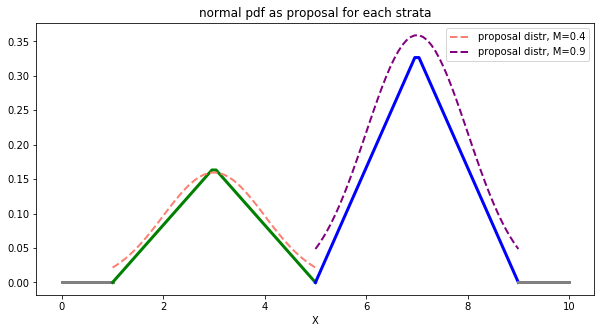

In [45]:
#stratified
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x1 = np.linspace(0, 1, 50)
x2 = np.linspace(1, 5, 50)
x3 = np.linspace(5, 9, 50)
x4 = np.linspace(9, 10, 50)
ax.plot(x1, vector_f_X(x1), color='gray', linewidth=3)
ax.plot(x2, vector_f_X(x2), color='green', linewidth=3)
ax.plot(x3, vector_f_X(x3), color='blue', linewidth=3)
ax.plot(x4, vector_f_X(x4), color='gray', linewidth=3)
ax.plot(x2, M_S1 * prop_strat_1(x=x2), '--', color='salmon', linewidth=2, label='proposal distr, M={}'.format(M_S1))
ax.plot(x3, M_S2 * prop_strat_2(x=x3), '--', color='purple', linewidth=2, label='proposal distr, M={}'.format(M_S2))

ax.set_xlabel('X')
ax.set_title('normal pdf as proposal for each strata')
ax.legend(loc='best')
plt.show()

In [46]:
proportion = 1./2
n_samples_1 = int(proportion * n_samples)
n_samples_2 = n_samples - n_samples_1
 
means = []
for i in range(n_simulations):
    means.append(1./3 * rejection(n_samples_1, prop_strat_1, M_S1, f_X_1, h)[1] + 2./3 * rejection(n_samples_2, prop_strat_2, M_S2, f_X_2, h)[1])
    
print('stratified mean: {}'.format(np.mean(means)))
print('stratified std: {}'.format(np.std(means)))

stratified mean: 0.05907423856374269
stratified std: 0.0009875824074502347


Alas, we do not see a significant reduction in variance using these particular two stata and the scheme of sampling equal number of points from each. From our discussion in the review, we see that the variance of the stratified sampling estimate depends on the variance of the estimates of each subintegral as well as on the number of points we sample in calculating each of these subintegrals. 

We encourage you to try out the following modifications to our naive implementaiton of stratified sampling to see if you can obtain a variance reduction:

1. subdivide the domain of $f_X$ to minimize $\mathrm{Var}[h(X|X\in D_j)]$, where $D_j$ is a strata (or a piece in your subdivision).
2. rather than sampling an equal number of points from each strata, sample more points from strata that are have greater probability mass and or on which $h(X|X\in D_j)$ has greater variance. 

Here again is a case where you can have explicity formulae for computing the variance associated to your choice of strata and sampling proportions (see review). If you have the desire to be very precise, we encourage you to write out the expression for the variance in this case and formally minimize it.


### WHAT ON EARTH IS THE POINT OF PROBLEM 2?
Most variance reduction methods, and indeed most models and algorithms in this class, do not work well in "factory settings" or arbitrary settings. Models or algorithms with theoretical performance gaurantees also come with parameters that must be tuned to satisfy specific conditions. Understanding and choosing parameters that satisfy these conditions is often subtle and time-consuming work!

## Problem 3: Linear Regression

Consider the following base Regression class, which roughly follows the API in the python package `scikit-learn`.

Our model is the the multivariate linear model whose MLE solution or equivalent cost minimization was talked about in lecture:

$$y = X\beta + \epsilon$$
where $y$ is a length $n$ vector, $X$ is an $n \times p$ matrix created by stacking the features for each data point, and $\beta$ is a $p$ length vector of coefficients.

The class showcases the API:

$fit(X, y)$: Fits linear model to $X$ and $y$.

$get\_params()$: Returns $\hat{\beta}$ for the fitted model. The parameters should be stored in a dictionary with keys "intercept" and "coef" that give us $\hat{\beta_0}$ and $\hat{\beta_{1:}}$. (The second value here is thus a numpy array of coefficient values)

$predict(X)$: Predict new values with the fitted model given $X$.

$score(X, y)$: Returns $R^2$ value of the fitted model.

$set\_params()$: Manually set the parameters of the linear model.



In [47]:
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params.get(k, None)
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v
                    
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()

### Part A:  a class for Ordinary Least Squares

Inherit from this class to create an ordinary Least Squares Linear Regression class. 

It's signature will look like this:

`class OLS(Regression):`

Implement `fit`, `predict` and `score`. This will involve some linear algebra. (You might want to read up on pseudo-inverses before you directly implement the linear algebra on the lecure slides).

#### $R^2$ score

To implement `score`, look below:

The $R^2$ score is defined as: $${R^{2} = {1-{SS_E \over SS_T}}}$$

Where:

$$SS_T=\sum_i (y_i-\bar{y})^2, SS_R=\sum_i (\hat{y_i}-\bar{y})^2, SS_E=\sum_i (y_i - \hat{y_i})^2$$
where  ${y_i}$ are the original data values, $\hat{y_i}$ are the predicted values, and $\bar{y_i}$ is the mean of the original data values.


** Solution **

The idea behind this part of the problem is to use inheritance to define a class *OLS* that will inherit from the *Regression* class that we've been given above. In *OLS* we'll implement predict, score, and fit while keeping get_params and set_params from our parent class *Regression*.  I've modified Regression slightly for better behavior in get_params and to use the items iterator in set_params.  Let's give it a go.

In [48]:
class OLS(Regression):
    def fit(self, X, y, fit_intercept=True):
        
        # convert X and y to numpy ndaarrays just in case
        #X = np.array(X)
        #y = np.array(y)
        
        # check if we're fitting the intercept -- in that case
        # we'll add a column of ones at the beginning and use
        # the first beta coefficient as the intercept
        if (fit_intercept):
            
            # create the column of ones and concatenate it to X
            X_plus = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)      
            
            # construct the Gram matrix (X_transpose * X)
            gram = X_plus.T@X_plus
            
            # generate our beta coefficient matrix by using pseudo inverse
            # (in case data isn't linearly independent)
            beta_coefs = np.linalg.pinv(gram)@X_plus.T@y
                        
            # Set our internal parameters
            self.set_params(intercept=beta_coefs[0], coef=beta_coefs[1:])
            
        else:
            # construct the Gram matrix (X_transpose * X)
            gram = X.T@X
            
            # generate our beta coefficient matrix by using pseudo inverse
            # (in case data isn't linearly independent)
            beta_coefs = np.linalg.pinv(gram)@X.T@y
            
            self.set_params(intercept=None, coef=beta_coefs[:])
            

    def predict(self, X):
        
        # convert X to numpy ndaarray just in case
        X = np.array(X)
        
        ## check if coefs is defined:
        if (type(self.get_params("coef")) == type(None)):
            raise(Exception("fit() has not been called on OLS Model!"))
        
        intercept = self.get_params("intercept")
        y_hat = X@self.get_params("coef")
        
        if intercept:
            y_hat = y_hat + intercept
            
        return y_hat
    
    def score(self, X, y):
        
        # If we have no coefficients predict will raise the exception
        y_hat = self.predict(X)
        
        # Make sure y is a numpy ndarray
        y = np.array(y)
        
        # calculate mean of y
        y_mean = y.mean()

        # Calculate residuals
        SSE = np.sum((y - y_hat)**2)
        SST = np.sum((y - y_mean)**2)
        
        Rsquared = 1 - float(SSE/SST)
        
        return Rsquared

In [49]:
from sklearn.datasets import make_regression
import numpy as np
np.random.seed(99)
X, y, coef = make_regression(30,10, 10, bias=1, noise=2, coef=True)
coef

array([ 76.6568183 ,  77.67682678,  63.78807738,  19.3299907 ,
        59.01638708,  53.13633737,  28.77629958,  10.01888939,
         9.25346811,  59.55220395])

In [50]:
lr = OLS()
lr.fit(X,y)
print("Our coefficients:")
print(lr.get_params('coef'))
y_hat = lr.predict(X)
print("Score:")
print(lr.score(X,y))

Our coefficients:
[ 77.20719705  76.51004831  62.97865316  18.4436452   58.50019885
  53.25126559  28.29088241   9.33333359  10.29584457  59.1606719 ]
Score:
0.9999155832062194


** For a fake dataset generated without much bias (i.e with very little in the way of an intercept) fitting a linear regression model from our custom OLS class with fit_intercept set to True gives us a very good fit in terms of $R^2$ (0.9999) and agreement between predictions and data **

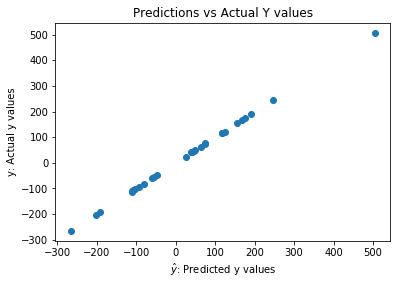

In [51]:
## Plot predictions vs data

plt.scatter(y_hat,y)
plt.title("Predictions vs Actual Y values")
plt.ylabel('y: Actual y values')
plt.xlabel('$\hat{y}$: Predicted y values')
plt.show()

In [52]:
from sklearn.datasets import make_regression
import numpy as np
np.random.seed(99)
X, y, coef = make_regression(30,10, 10, bias=100, noise=2, coef=True)
coef

array([ 76.6568183 ,  77.67682678,  63.78807738,  19.3299907 ,
        59.01638708,  53.13633737,  28.77629958,  10.01888939,
         9.25346811,  59.55220395])

With Intercept:
Our coefficients:
[ 77.20719705  76.51004831  62.97865316  18.4436452   58.50019885
  53.25126559  28.29088241   9.33333359  10.29584457  59.1606719 ]
Intercept:
100.345803571
Score:
0.9999155832062194


Without Intercept:
With Intercept:
Our coefficients:
[  77.11414732  112.30331534   77.21630892   35.53290652   80.87497626
   65.50899916   14.20918347   10.49516544    1.70506782   58.0195541 ]
Intercept:
None
Score:
0.6359028400617639


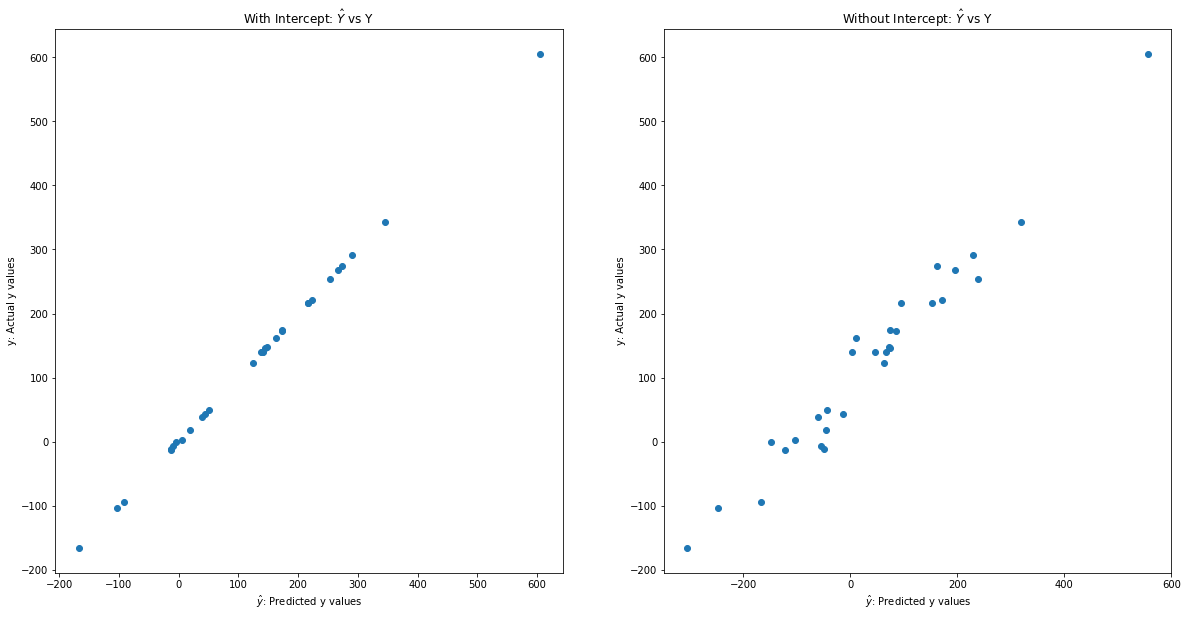

In [53]:
lr = OLS()
lr.fit(X,y, fit_intercept=True)
print("With Intercept:")
print("Our coefficients:")
print(lr.get_params('coef'))
print("Intercept:")
print(lr.get_params('intercept'))
y_hat_intercept = lr.predict(X)
print("Score:")
print(lr.score(X,y))

print("\n\nWithout Intercept:")
lr.fit(X,y, fit_intercept=False)
print("With Intercept:")
print("Our coefficients:")
print(lr.get_params('coef'))
print("Intercept:")
print(lr.get_params('intercept'))
y_hat_no_intercept = lr.predict(X)
print("Score:")
print(lr.score(X,y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(y_hat_intercept,y)
ax1.set_title("With Intercept: $\hat{Y}$ vs Y ")
ax1.set_ylabel('y: Actual y values')
ax1.set_xlabel('$\hat{y}$: Predicted y values')

ax2.scatter(y_hat_no_intercept,y)
ax2.set_title("Without Intercept: $\hat{Y}$ vs Y ")
ax2.set_ylabel('y: Actual y values')
ax2.set_xlabel('$\hat{y}$: Predicted y values')


** For a fake dataset generated without much more bias bias we see (as we should) a marked difference between our model set with fit_intercept=True where we get a great fit between predicted and actual y values as well as a very good $R^2$ score.  As we expect, fitting a linear regression model from our custom OLS class with fit_intercept set to False gives us a much worse fit in terms of $R^2$ (0.6359) and much less agreement between predictions and data. **